# MATH 693A Advanced Numerical Methods: Computational Optimization HW 4
###  By: Will McGrath


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 1 
### Program that trust-region method using the Steihaug method (see Lecture 15 and/or Algorithm 7.2 in the text Numerical Optimization by Nocedal and Wright 2006). Choose $B_k$ to be the exact Hessian, and use it to minimize the function: $f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2$. 

### Use the tolerance $\epsilon = 10−6$. $\| \nabla{f(x_k)} \|< 10^{-8}$ as the stopping criteria for your optimization algorithm. Use an initial trust region radius of 1. Set maximum trust region radius to 300. Use the initial point: $x_0 = [-1.2, 1]$ and then try another point $x_0 = [2.8, 4]$. Do the following for each of the initial points.

In [2]:
# Rosenbrock function
def objective_func(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return 100*(y - x**2)**2 + (1 - x)**2

def gradient(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]

    return np.array([400*x**3 - 400*x*y + 2*x - 2, 200*(y - x**2)])

def hessian(xbar_k):
    x = xbar_k[0]
    y = xbar_k[1]
    
    return np.array([[1200*x**2 - 400*y + 2, -400*x],[-400*x, 200]])

## Part A

### Your program should indicate, at every iteration, whether Steihaug method encountered negative curvature, reached the trust-region boundary, or met the stopping test. Hand in your output.
> Note: Use Steihaug method to find pk and feed it into tr method

> Note: Quasi-Newton = just a different, modified hessian but methods are similar. The hessian doesn't have to be positive definite bc you can edit it to make it positive def or use a method that doesn't require it

In [3]:
# compute tau variable s.t. pbar_k = ||pbar_k + tau*dbar_k|| = trust_region
# simplifies to quadratic equation
def compute_tau_star(pbar_k, dbar_k, trust_reg):
    a_coeff = np.dot(dbar_k, dbar_k)
    b_coeff = 2 * np.dot(dbar_k, pbar_k)
    c_coeff = np.dot(pbar_k, pbar_k) - trust_reg**2

    # solve quadratic equation
    tau_1 = (-b_coeff + np.sqrt(b_coeff * b_coeff - 4 * a_coeff * c_coeff)) / (2 * a_coeff) 
    tau_2 = (-b_coeff - np.sqrt(b_coeff * b_coeff - 4 * a_coeff * c_coeff)) / (2 * a_coeff) 

    # conditions to choose tau_star
    if tau_1 >= 0 and tau_2 < 0:
        return tau_1

    if tau_2 >= 0 and tau_1 < 0:
        return tau_2

    if tau_1 >= 0 and tau_2 >= 0:
        return min(tau_1, tau_2)

In [4]:
# trust_reg = delta
# eps = tolerance
# don't need Hk (Bk inverse or hessian inverse)
def steihaug_method(xbar_k, grad, Bk, trust_reg, eps=10**(-6)):
    pbar_k = [0, 0]
    rbar_k = grad(xbar_k) # residuals
    dbar_k = -rbar_k

    if np.linalg.norm(rbar_k) < eps:
        return pbar_k 

    while True:
        if np.dot(dbar_k, np.dot(Bk, dbar_k)) <= 0: # negative curvature
            tau_star = compute_tau_star(pbar_k, dbar_k, trust_reg)
            pbar_k = pbar_k + tau_star * dbar_k
            print('Negative curvature')
            return pbar_k
        
        alpha_k = np.dot(rbar_k, rbar_k) / np.dot(dbar_k, np.dot(Bk, dbar_k))
        pbar_kp1 = pbar_k + alpha_k * dbar_k
        if np.linalg.norm(pbar_kp1) >= trust_reg: # step outside trust region
            tau_star = compute_tau_star(pbar_k, dbar_k, trust_reg)
            pbar_k = pbar_k + tau_star * dbar_k
            print('Reached the trust region boundary')
            return pbar_k

        rbar_kp1 = rbar_k + alpha_k * np.dot(Bk, dbar_k)
        if np.linalg.norm(rbar_kp1) <= (eps * np.linalg.norm(rbar_k)):
            return pbar_kp1
        
        # find Bk+1
        Bkp1 = np.dot(rbar_kp1, rbar_kp1) / np.dot(rbar_k, rbar_k)
        dbar_kp1 = -rbar_kp1 + np.dot(Bkp1, dbar_k)

        # set next iteration
        Bk = Bkp1
        dbar_k = dbar_kp1
        rbar_k = rbar_kp1
        pbar_k = pbar_kp1


In [5]:
# trust region algorithm 
def trust_region(x0, obj_func, grad, hess, grad_stop_criteria, eta=0.15, initial_trust_radius=1, max_trust_radius=300):
    xbar_k = x0 # xbar_k = xbar_transposed
    trust_reg = initial_trust_radius
    k = 1
    k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list = [], [], [], [], [], []

    while np.linalg.norm(grad(xbar_k)) > grad_stop_criteria:
        Bk = hess(xbar_k)

        # get approx. step pbar_k by steihaug method (gives minimized pbar_k)
        pbar_k = steihaug_method(xbar_k, grad, Bk, trust_reg)
        print(pbar_k)

        # define a ratio measuring the success of a step
        # given a step pbar_k we define the ratio: rho_k = actual reduction / predicted reduction 
        mk_0 = obj_func(xbar_k)
        mk_pbar_k = obj_func(xbar_k) + np.dot(grad(xbar_k),  pbar_k) + 0.5 * np.dot(pbar_k, np.dot(Bk, pbar_k))
        act_reduc = obj_func(xbar_k) - obj_func(xbar_k + pbar_k)
        pred_reduc = mk_0 - mk_pbar_k
        rho_k = act_reduc / pred_reduc

        # rho is close to zero or negative, therefore the trust region must shrink
        if rho_k < 0.25:
            trust_reg = 0.25 * trust_reg

        # rho is close to one and pbar_k has reached the boundary of the trust region, therefore the trust region must be expanded
        # euclidean norm of pbar_k = sqrt(np.dot(pbar_k, pbar_k)) = np.linalg.norm(pbar_k)
        else:
            if rho_k > 0.75 and np.linalg.norm(pbar_k) == trust_reg:
                trust_reg = min(2 * trust_reg, max_trust_radius)
            else:
                trust_reg = trust_reg
        
        # add to dataframe
        if k == 1:
            xbar_list.append(x0)
            k_list.append(0)
            obj_func_xbar_list.append(obj_func(x0))
            pbar_list.append(np.nan)
            rho_list.append(np.nan)
            trust_reg_list.append(np.nan)

        # choose position for the next iteration
        if rho_k > eta:
            xbar_k = xbar_k + pbar_k
        else:
            xbar_k = xbar_k
        
        xbar_list.append(xbar_k)
        k_list.append(k)
        obj_func_xbar_list.append(obj_func(xbar_k))
        pbar_list.append(pbar_k)
        rho_list.append(rho_k)
        trust_reg_list.append(trust_reg)

        k = k + 1

        trust_region_steihaug_df = pd.DataFrame(
        [[k_list, xbar_list, obj_func_xbar_list, pbar_list, rho_list, trust_reg_list]], 
        columns=['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']
    ).explode(['iteration', 'xbar', 'f(xbar)', 'pbar', 'rho', 'trust_region']).reset_index(drop=True)

    return trust_region_steihaug_df

In [ ]:
trust_region_steihaug_df = trust_region([-1.2, 1], objective_func, gradient, hessian, 10**(-8))
trust_region_steihaug_df

## Part B

### State the total number of iterations obtained in your optimization algorithm.

## Part C

### Plot the objective function $f(x)$. On the same figure, plot the $x_k$ values at the different iterates of your optimization algorithm.

In [6]:
def contourplot(objective_func, x_range, y_range, title, ncontours=500):
    xmin = x_range[0]
    xmax = x_range[1]
    ymin = y_range[0]
    ymax = y_range[1]

    # range of x and y 
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x,y)
    xbar = [X,Y]
    Z = objective_func(xbar)

    plt.figure(figsize=(10, 6))
    plt.contour(X, Y, Z, ncontours, cmap = 'hsv'); # plot the contours
    plt.scatter(1, 1, marker="x", s=150, color="black", label = 'Minimum');  # mark the minimum
    plt.legend(loc=0)
    plt.title("Minimize $f(x,y)=100(y-x^2)^2 + (1-x)^2$ with %s"%title);
    plt.xlabel('x')
    plt.ylabel('y')

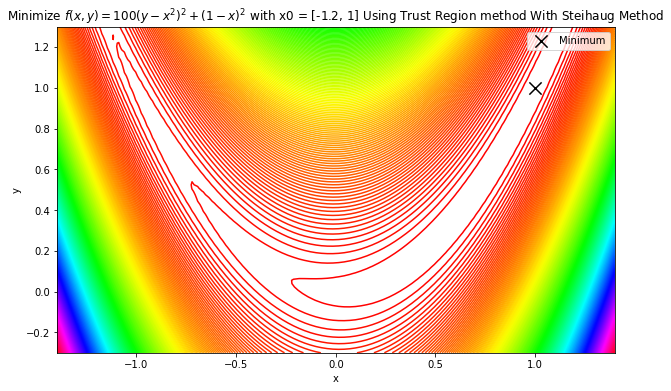

In [7]:
# plot objective function
contourplot(objective_func, [-1.4, 1.4], [-0.3, 1.3], "x0 = [-1.2, 1] Using Trust Region method With Steihaug Method")

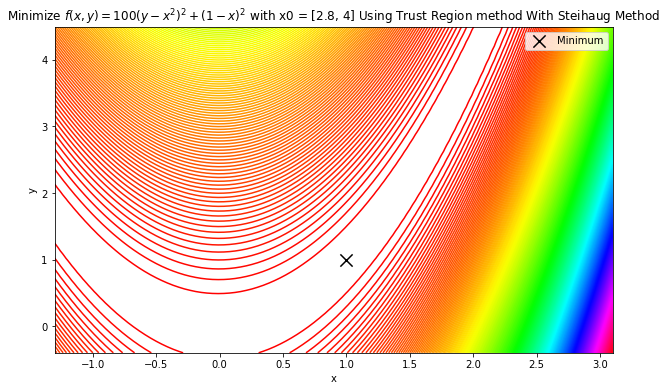

In [8]:
# plot objective function
contourplot(objective_func, [-1.3, 3.1], [-0.4, 4.5], "x0 = [2.8, 4] Using Trust Region method With Steihaug Method")

## Part D

### Plot the size of the objective function as a function of the iteration number. Use semi-log plot.

## Part E

### Determine the minimizer of the function $x_*$.

### The minimizer for the function: $f(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2$ is $x_*$ where $x_* = [1, 1]$. 

# Problem 2

### Implement the standard CG algorithm, and use it to solve linear systems in which A is the Hilbert matrix, whose elements are $\alpha_{ij} = 1 / (i + j - 1)$. Set the right-hand-side to be all ones $\vec{b} = ones(n,1)$, and the initial point to be the origin $\vec{x_o} = zeros(n,1)$. In the stopping criteria, use $\| \nabla{r_k)} \|> 10^{-6}$. 

In [9]:
# congujate gradient method
def linear_conjugate_gradient(A, b, x0, stopping_criteria = 10**(-6)):
    xk = x0
    rk = np.dot(A, xk) - b # residuals
    pk = -rk
    k = 0 # count 
    xk_list, rk_norm_list, residual_list, iteration_list = [], [], [], []

    while np.linalg.norm(rk) > stopping_criteria:
        
        ap_k = np.dot(A, pk) 
        rk_rk = np.dot(rk, rk)
        alpha = rk_rk / np.dot(pk, ap_k)

        if k == 0:
            iteration_list.append(k)
            residual_list.append(np.round(rk, 4))
            xk_list.append(np.round(xk, 4))
            rk_norm_list.append(np.linalg.norm(np.round(rk, 4)))

        xk = xk + alpha * pk
        rk = rk + alpha * ap_k
        beta = np.dot(rk, rk) / rk_rk
        pk = -rk + beta * pk

        k += 1
        iteration_list.append(k)
        residual_list.append(np.round(rk, 4))
        xk_list.append(np.round(xk, 4))
        rk_norm_list.append(np.linalg.norm(np.round(rk, 4)))

        #print('Iteration: {}\n x: {}, Residuals: {}\n'.format(k, np.round(xk, 4), np.round(rk, 4)))

    #print('\nSolution: x = {}'.format(np.round(xk, 4)))
    df = pd.DataFrame([[iteration_list, xk_list, residual_list, rk_norm_list]], 
        columns=['iteration', 'xbar', 'residuals', 'norm_residuals']
    ).explode(['iteration', 'xbar', 'residuals', 'norm_residuals']).reset_index(drop=True)


    return df

In [10]:
# hilbert matrix
def hilbert(n):
    matrix = []
    for i in range(1, n + 1):
        row = []
        for j in range(1, n + 1):
            row.append(1 / (i + j - 1))
        matrix.append(row)
        
    return matrix

def bn(n):
    return np.ones(n)

def xn(n):
    return np.zeros(n)

In [11]:
linear_conjugate_gradient(hilbert(5), bn(5), xn(5))

,iteration,xbar,residuals,norm_residuals
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -1.0, -1.0, -1.0, -1.0]",2.236068
1,1,"[0.7744, 0.7744, 0.7744, 0.7744, 0.7744]","[0.7683, 0.1229, -0.1537, -0.315, -0.4226]",0.952276
2,2,"[-1.7326, 1.024, 2.2054, 2.8945, 3.354]","[-0.091, 0.1643, 0.0811, -0.028, -0.1263]",0.24205
3,3,"[2.7207, -12.4359, -2.7805, 7.9352, 17.2194]","[0.0037, -0.0231, 0.0243, 0.0156, -0.0205]",0.042443
4,4,"[-3.8061, 45.656, -86.4661, -36.193, 99.2417]","[-0.0001, 0.0008, -0.0027, 0.0034, -0.0015]",0.004664
5,5,"[5.0002, -119.9999, 630.0001, -1119.9999, 630.0]","[0.0002, 0.0001, 0.0001, 0.0001, 0.0001]",0.000283
6,6,"[5.0, -120.0, 630.0, -1120.0, 630.0]","[0.0, -0.0, -0.0, -0.0, -0.0]",0.0


## Part A

### For dimensions n = 5, 8, 12, 20, plot the norm of the residual as a function of the iteration (on the same figure); stop when the norm is less than $10^{-6}$. Use semi-log plot.

In [12]:
n5_df = linear_conjugate_gradient(hilbert(5), bn(5), xn(5))
n8_df = linear_conjugate_gradient(hilbert(8), bn(8), xn(8))
n12_df = linear_conjugate_gradient(hilbert(12), bn(12), xn(12))
n20_df = linear_conjugate_gradient(hilbert(20), bn(20), xn(20))

Text(0, 0.5, 'Residual Norm')

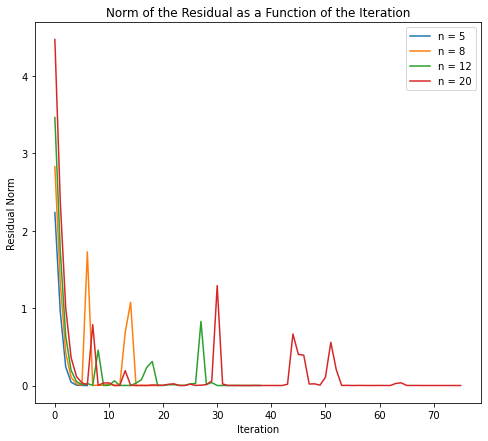

In [13]:
plt.figure(figsize=(8,7))
plt.plot(n5_df['iteration'].to_list(), n5_df['norm_residuals'].to_list(), label = 'n = 5')
plt.plot(n8_df['iteration'].to_list(), n8_df['norm_residuals'].to_list(), label = 'n = 8')
plt.plot(n12_df['iteration'].to_list(), n12_df['norm_residuals'].to_list(), label = 'n = 12')
plt.plot(n20_df['iteration'].to_list(), n20_df['norm_residuals'].to_list(), label = 'n = 20')
plt.legend(loc=0)
plt.title('Norm of the Residual as a Function of the Iteration')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')

Text(0, 0.5, 'Semi-Log Residual Norm')

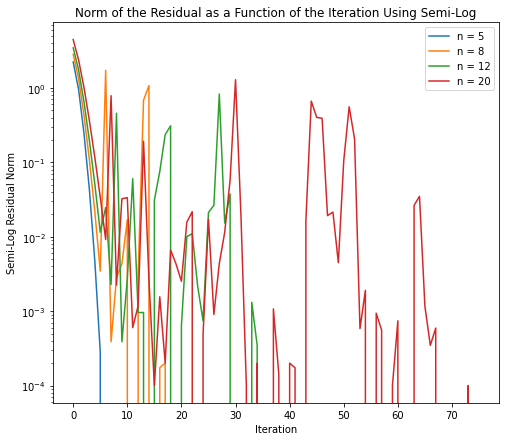

In [14]:
plt.figure(figsize=(8,7))
plt.semilogy(n5_df['iteration'].to_list(), n5_df['norm_residuals'].to_list(), label = 'n = 5')
plt.semilogy(n8_df['iteration'].to_list(), n8_df['norm_residuals'].to_list(), label = 'n = 8')
plt.semilogy(n12_df['iteration'].to_list(), n12_df['norm_residuals'].to_list(), label = 'n = 12')
plt.semilogy(n20_df['iteration'].to_list(), n20_df['norm_residuals'].to_list(), label = 'n = 20')
plt.legend(loc=0)
plt.title('Norm of the Residual as a Function of the Iteration Using Semi-Log')
plt.xlabel('Iteration')
plt.ylabel('Semi-Log Residual Norm')

## Part B

### Plot your number of iterations against n for n = 5, 8, 12, 20.

Text(0, 0.5, 'Iteration')

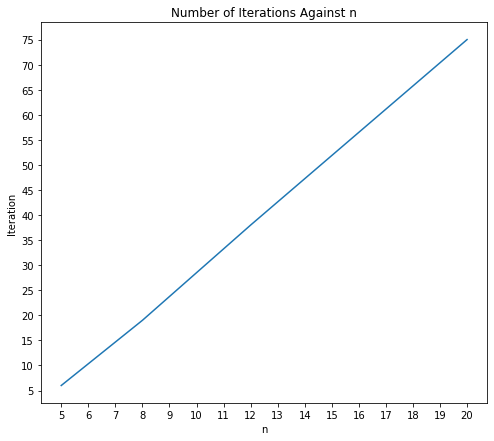

In [15]:
plt.figure(figsize=(8,7))
max_iteration_list = [max(n5_df['iteration'].to_list()), max(n8_df['iteration'].to_list()),
                     max(n12_df['iteration'].to_list()), max(n20_df['iteration'].to_list())]
                     
plt.plot([5, 8, 12, 20], max_iteration_list)
plt.title('Number of Iterations Against n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.yticks(np.arange(5,80,5))
plt.ylabel('Iteration')

## Part C

### Compute the condition number for your Hilbert matrices, generate a plot of the condition number against the matrix size n. Use semi-log plot.
>Note: The Hilbert matrix shows up in the normal equations in least squares approximations and is an example of a matrix with a nasty condition number. Note that the Hilbert matrix is a square matrix, therefore a matrix size n denotes an 𝑛 × 𝑛 matrix.


>Note: The condition number of x is defined as the norm of x times the norm of the inverse of x [1]; the norm can be the usual L2-norm (root-of-sum-of-squares) or one of a number of other matrix norms.

Text(0, 0.5, 'Condition Number')

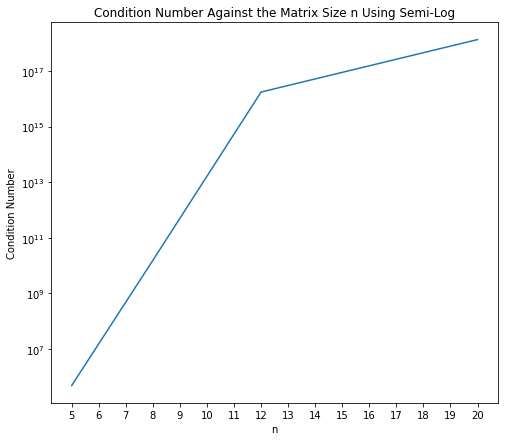

In [16]:
hilbert_matrix_list = [hilbert(n) for n in [5, 8, 12, 20]]
condition_list = [np.linalg.cond(a) for a in hilbert_matrix_list]

plt.figure(figsize=(8,7))
plt.semilogy([5, 8, 12, 20], condition_list)
plt.title('Condition Number Against the Matrix Size n Using Semi-Log')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Condition Number')

## Part D

### Plot the eigenvalues for n = 5, 8, 12, 20 on the same figure in order to show the spread of the eigenvalues.
>Note: An eigenvalue is a number, telling you how much variance there is in the data in that direction, in the example above the eigenvalue is a number telling us how spread out the data is on the line. The eigenvector with the highest eigenvalue is therefore the principal component. 

Text(0, 0.5, 'Eigenvalues')

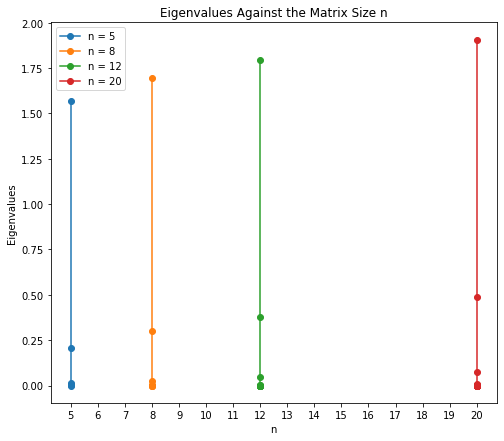

In [17]:
eigenvalue_list = [np.linalg.eig(e) for e in hilbert_matrix_list]
ones_list = [np.ones(n) * n for n in [5, 8, 12, 20]]

plt.figure(figsize=(8,7))
for i in range(len([5, 8, 12, 20])):
    plt.plot(ones_list[i], eigenvalue_list[i][0], marker='o')
plt.legend(['n = 5', 'n = 8', 'n = 12', 'n = 20'], loc=0);
plt.title('Eigenvalues Against the Matrix Size n')
plt.xticks(np.arange(5,21,1))
plt.xlabel('n')
plt.ylabel('Eigenvalues')

## Part E

### From the formulas provided in the Lecture 11, estimate how many steepest descent iterations you would need to solve the problem to the same precision. What can you say about your estimate, is it a good estimate?

## For the Conjugate Gradient (CG) method: $\vert\vert \bar{x_k} - \bar{x}^* \vert\vert_A \le 2\begin{bmatrix} \frac{\sqrt{K(A)} - 1}{\sqrt{K(A)} + 1} \end{bmatrix}^k \vert\vert \bar{x_0} - \bar{x}^* \vert\vert_A$, where $K(A) = \frac{\lambda_n}{\lambda_1} $. For Steepest Descent (SD) method: $\vert\vert \bar{x_{k+1}} - \bar{x}^* \vert\vert_A \le 2\begin{bmatrix} \frac{K(A) - 1}{K(A)+ 1} \end{bmatrix}^k \vert\vert \bar{x_0} - \bar{x}^* \vert\vert_A$, where $K(A) = \frac{\lambda_n}{\lambda_1}$. This means that if we want the same precision, $10^{-6}$, as the conjugate gradient method using the steepest descent method we would have $\sim \sqrt{K(A)}$ more iterations. For example 75 iterations using the CG method whould be about 700 iterations using the SD method. 


### Resources
- [CG Method](https://towardsdatascience.com/complete-step-by-step-conjugate-gradient-algorithm-from-scratch-202c07fb52a8)